# Wasserstein Generative Adversarial Network

**Main Improvements:**

1. Earth Mover's Distance (Remove Sigmoid Layer from D).  
2. Weight Clipping after every optimizer step.  

## Imports

### wandb (interactive cell)

In [1]:
!pip -qqq install wandb pytorch-lightning torchmetrics > /dev/null

import wandb
from pytorch_lightning.loggers import WandbLogger

wandb.login()

# API Key:
# d926baa25b6a14ffa4e5c30a6f3bbffbeca8fcf1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.0/719.0 kB 57.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 43.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 22.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 205.1/205.1 kB 23.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 57.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 10.5 MB/s eta 0:00:00


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

### Lightning

In [2]:
try:
  import lightning.pytorch as pl
except:
  print("[!] Couldn't find pytorch-lightning.\nInstalling it...\n")
  !pip install lightning > /dev/null
  import lightning.pytorch as pl

[!] Couldn't find pytorch-lightning.
Installing it...



In [3]:
from lightning.pytorch.utilities.model_summary import ModelSummary

In [4]:
from pytorch_lightning import seed_everything

### standard imports

In [5]:
import os
import shutil
import pathlib

from PIL import Image
import numpy as np
import cv2 as cv
import random
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

from torch.utils.data import DataLoader, random_split
from torch.utils.data import Dataset

import torchvision
from torchvision import datasets

In [6]:
import torchvision.transforms as T
from torchvision.transforms import Compose, ToTensor, Resize
from torchvision.utils import make_grid

### Albumentations

In [7]:
try:
  import albumentations as A
  from albumentations.pytorch import ToTensorV2
except:
  print("[!] Couldn't find albumentations... installing it.")
  !pip install -U albumentations
  import albumentations as A
  from albumentations.pytorch import ToTensorV2

### Custom Definitions

In [9]:
# Folder Utilities ----------------------------

## Create dir if it doesn't exist
def create_dir(dir_name):
  if not os.path.exists(f'/content/{dir_name}'):
    os.mkdir(f'/content/{dir_name}')

## Delete dir: checkpoints
def delete_dir(dir_name):
  if os.path.isdir(f'/content/{dir_name}'):
    shutil.rmtree(f'/content/{dir_name}')

# ---------------------------------------------

## Config File, Seeds & Devices

In [10]:
# Log this config file to wandb
CONFIG = dict(
    seed=42,
    DATA_ROOT = '/content/',
    BATCH_SIZE = 64,
    WORKERS = 2,
    IMG_SIZE = (28,28),
    NUM_EPOCHS = 20,
    nz=100,
    lr = 0.00005,
    nc = 1,  
    disc_steps=5,
    checkpoint_path='/content/checkpoints/',
    clipping_c=0.01
    )

In [11]:
seed_everything(CONFIG['seed'])

INFO:lightning_fabric.utilities.seed:Global seed set to 42


42

In [12]:
# device = torch.device('cpu')
if torch.cuda.is_available():
  device = torch.device('cuda')
else:
  device = torch.device('cpu')

device

device(type='cuda')

## Transforms

In [192]:
# import torchvision.transforms as T
# train_transform = A.Compose(
#     [
#         A.SmallestMaxSize(max_size=160),
#         A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
#         A.RandomCrop(height=128, width=128),
#         A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
#         A.RandomBrightnessContrast(p=0.5),
#         A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
#         ToTensorV2(),
#     ]
# )
train_transform = Compose([
    # T.RandomAffine(degrees=15, translate=(0.1,0.1), scale=(0.8,1.2)),
    # T.RandomHorizontalFlip(p=0.5),
    T.GaussianBlur(kernel_size=3),
    ToTensor()
])

## Dataset & DataLoaders (use lightning's Data Module class this time)

In [193]:
train_data = torchvision.datasets.FashionMNIST(root="train_data", 
                                               train = True, 
                                               transform = train_transform, 
                                               target_transform = None, 
                                               download = True)

In [194]:
test_data = torchvision.datasets.FashionMNIST(root="test_data",
                                              train=False, 
                                              transform=Compose([ToTensor()]), 
                                              target_transform=None, 
                                              download=True)

In [195]:
print(len(test_data), len(train_data))

10000 60000


In [196]:
train_dataloader = DataLoader(train_data, batch_size=CONFIG['BATCH_SIZE'], shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=CONFIG['BATCH_SIZE'], shuffle=True)

## Sanity Visualizations

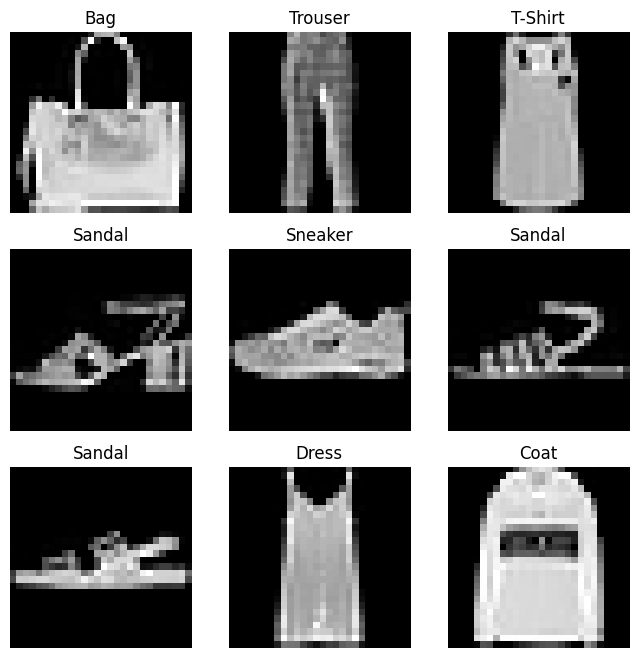

In [197]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    # print(img.shape)
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

## Model Arch

In [198]:
from torchvision import models
from torchsummary import summary

### Discriminator

> No Sigmoid at the end!   
> Values can range from -∞ to ∞

In [199]:
class Discriminator(nn.Module):
  def __init__(self, img_shape):
    super().__init__()

    self.img_shape = img_shape
    self.model = nn.Sequential(
        nn.Linear(int(np.prod(self.img_shape)), 512),
        nn.ReLU(inplace=True),
        nn.Linear(512, 256),
        nn.ReLU(inplace=True),
        nn.Linear(256, 128),
        nn.ReLU(inplace=True),   
        nn.Linear(128,1)
    )
  
  def forward(self, x):
    x = x.view(x.size(0), -1)
    real_or_fake = self.model(x)
    return real_or_fake

In [200]:
d = Discriminator(img_shape=CONFIG['IMG_SIZE']).to(device)
summary(d, (1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 512]         401,920
              ReLU-2                  [-1, 512]               0
            Linear-3                  [-1, 256]         131,328
              ReLU-4                  [-1, 256]               0
            Linear-5                  [-1, 128]          32,896
              ReLU-6                  [-1, 128]               0
            Linear-7                    [-1, 1]             129
Total params: 566,273
Trainable params: 566,273
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 2.16
Estimated Total Size (MB): 2.18
----------------------------------------------------------------


### Generator

In [201]:
class Generator(nn.Module):
  def __init__(self, img_shape, latent_dim: int = 100):
    super().__init__()

    self.img_shape = img_shape

    self.model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(latent_dim, 128),
        nn.ReLU(inplace=True),
        nn.Linear(128, 256),
        nn.ReLU(inplace=True),
        nn.Linear(256, 512),
        nn.ReLU(inplace=True),
        nn.Linear(512, 784),
        nn.Sigmoid()          
    )
  
  def forward(self, z):
    img = self.model(z)
    img = img.view(img.size(0), *self.img_shape)
    return img

In [202]:
g = Generator(CONFIG['IMG_SIZE']).to(device)
summary(g, (100, 1, 1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 100]               0
            Linear-2                  [-1, 128]          12,928
              ReLU-3                  [-1, 128]               0
            Linear-4                  [-1, 256]          33,024
              ReLU-5                  [-1, 256]               0
            Linear-6                  [-1, 512]         131,584
              ReLU-7                  [-1, 512]               0
            Linear-8                  [-1, 784]         402,192
           Sigmoid-9                  [-1, 784]               0
Total params: 579,728
Trainable params: 579,728
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.03
Params size (MB): 2.21
Estimated Total Size (MB): 2.24
-------------------------------------------

## FID

In [203]:
class InceptionV3(nn.Module):
    """Pretrained InceptionV3 network returning feature maps"""

    # Index of default block of inception to return,
    # corresponds to output of final average pooling
    DEFAULT_BLOCK_INDEX = 3

    # Maps feature dimensionality to their output blocks indices
    BLOCK_INDEX_BY_DIM = {
        64: 0,   # First max pooling features
        192: 1,  # Second max pooling featurs
        768: 2,  # Pre-aux classifier features
        2048: 3  # Final average pooling features
    }

    def __init__(self,
                 output_blocks=[DEFAULT_BLOCK_INDEX],
                 resize_input=True,
                 normalize_input=True,
                 requires_grad=False):
        
        super(InceptionV3, self).__init__()

        self.resize_input = resize_input
        self.normalize_input = normalize_input
        self.output_blocks = sorted(output_blocks)
        self.last_needed_block = max(output_blocks)

        assert self.last_needed_block <= 3, \
            'Last possible output block index is 3'

        self.blocks = nn.ModuleList()

        
        inception = torchvision.models.inception_v3(pretrained=True)

        # Block 0: input to maxpool1
        block0 = [
            inception.Conv2d_1a_3x3,
            inception.Conv2d_2a_3x3,
            inception.Conv2d_2b_3x3,
            nn.MaxPool2d(kernel_size=3, stride=2)
        ]
        self.blocks.append(nn.Sequential(*block0))

        # Block 1: maxpool1 to maxpool2
        if self.last_needed_block >= 1:
            block1 = [
                inception.Conv2d_3b_1x1,
                inception.Conv2d_4a_3x3,
                nn.MaxPool2d(kernel_size=3, stride=2)
            ]
            self.blocks.append(nn.Sequential(*block1))

        # Block 2: maxpool2 to aux classifier
        if self.last_needed_block >= 2:
            block2 = [
                inception.Mixed_5b,
                inception.Mixed_5c,
                inception.Mixed_5d,
                inception.Mixed_6a,
                inception.Mixed_6b,
                inception.Mixed_6c,
                inception.Mixed_6d,
                inception.Mixed_6e,
            ]
            self.blocks.append(nn.Sequential(*block2))

        # Block 3: aux classifier to final avgpool
        if self.last_needed_block >= 3:
            block3 = [
                inception.Mixed_7a,
                inception.Mixed_7b,
                inception.Mixed_7c,
                nn.AdaptiveAvgPool2d(output_size=(1, 1))
            ]
            self.blocks.append(nn.Sequential(*block3))

        for param in self.parameters():
            param.requires_grad = requires_grad

    def forward(self, inp):
        """Get Inception feature maps
        Parameters
        ----------
        inp : torch.autograd.Variable
            Input tensor of shape Bx3xHxW. Values are expected to be in
            range (0, 1)
        Returns
        -------
        List of torch.autograd.Variable, corresponding to the selected output
        block, sorted ascending by index
        """
        outp = []
        if inp.shape[1] == 1:
          inp = inp.expand(inp.shape[0], 3, *inp.shape[2:])
          print(inp.shape)
        x = inp

        if self.resize_input:
            x = F.interpolate(x,
                              size=(299, 299),
                              mode='bilinear',
                              align_corners=False)

        if self.normalize_input:
            x = 2 * x - 1  # Scale from range (0, 1) to range (-1, 1)

        for idx, block in enumerate(self.blocks):
            x = block(x)
            if idx in self.output_blocks:
                outp.append(x)

            if idx == self.last_needed_block:
                break

        return outp
    
    
block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[2048]
model_inc = InceptionV3([block_idx])
model_inc = model_inc.cuda()


def calculate_activation_statistics(images,model,batch_size=128, dims=2048,
                    cuda=False):
    model.eval()
    act=np.empty((len(images), dims))
    
    if cuda:
        batch=images.cuda()
    else:
        batch=images
    pred = model(batch)[0]

        # If model output is not scalar, apply global spatial average pooling.
        # This happens if you choose a dimensionality not equal 2048.
    if pred.size(2) != 1 or pred.size(3) != 1:
        pred = nn.functional.adaptive_avg_pool2d(pred, output_size=(1, 1))

    act= pred.cpu().data.numpy().reshape(pred.size(0), -1)
    
    mu = np.mean(act, axis=0)
    sigma = np.cov(act, rowvar=False)
    return mu, sigma


from scipy.linalg import sqrtm
def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    """
    The Frechet distance between two multivariate Gaussians X_1 ~ N(mu_1, C_1)
    and X_2 ~ N(mu_2, C_2) is:
            d^2 = ||mu_1 - mu_2||^2 + Tr(C_1 + C_2 - 2*sqrt(C_1*C_2))
    """

    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)

    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    assert mu1.shape == mu2.shape, \
        'Training and test mean vectors have different lengths'
    assert sigma1.shape == sigma2.shape, \
        'Training and test covariances have different dimensions'

    diff = mu1 - mu2
    
    covmean, _ = sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        msg = ('fid calculation produces singular product; '
               'adding %s to diagonal of cov estimates') % eps
        print(msg)
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = np.linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))

    
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError('Imaginary component {}'.format(m))
        covmean = covmean.real

    tr_covmean = np.trace(covmean)

    return (diff.dot(diff) + np.trace(sigma1) +
            np.trace(sigma2) - 2 * tr_covmean)


def calculate_fretchet(images_real,images_fake,model):
     mu_1,std_1=calculate_activation_statistics(images_real,model,cuda=True)
     mu_2,std_2=calculate_activation_statistics(images_fake,model,cuda=True)
    
     """get fretched distance"""
     fid_value = calculate_frechet_distance(mu_1, std_1, mu_2, std_2)
     return fid_value

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Lightning Recipe

In [204]:
class LIT_WGAN(pl.LightningModule):
  
  def __init__(self, 
               discriminator_model, 
               generator_model, 
               latent_dim: int = 100, 
               lr: float = 0.003, 
               clipping_c: float = 0.01,
               disc_steps: int = 5,
               isGP=False):
    
    super().__init__()
    self.save_hyperparameters(ignore=[discriminator_model, generator_model])
    self.automatic_optimization = False

    self.discriminator = discriminator_model
    self.generator = generator_model
    self.weight_cliping_limit = clipping_c

    self.isGP = isGP
  
  def configure_optimizers(self):
    lr = self.hparams.lr

    optim_g = torch.optim.RMSprop(self.generator.parameters(), lr=lr)
    optim_d = torch.optim.RMSprop(self.discriminator.parameters(), lr=lr)

    return [optim_g, optim_d], []

  def compute_gradient_penalty(self, real_samples, fake_samples):
    # Random weight term for interpolation between real and fake samples
    alpha = torch.Tensor(np.random.random((real_samples.size(0), 1, 1, 1))).to(self.device)

    # Get random interpolation between real and fake samples
    # print((torch.sub(alpha, 1) * fake_samples).shape)
    interpolates = (alpha * real_samples + (torch.sub(alpha,1) * fake_samples)).requires_grad_(True)
    interpolates = interpolates.to(self.device)
    # print("interpolates.shape:",interpolates.shape)
    d_interpolates = self.discriminator(interpolates)
    # print("d_interpolates.shape:", d_interpolates.shape)
    fake = torch.Tensor(real_samples.shape[0], 1).fill_(1.0).to(self.device)
    # Get gradient w.r.t. interpolates
    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    gradients = gradients.view(gradients.size(0), -1).to(self.device)
    # print("gradients.shape:", gradients.shape)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

  def forward(self, z):
    return self.generator(z)
 

  def test_step(self, batch, batch_idx): # Use for Exploring the latent space 
    imgs, _ = batch
    pass

  def validation_step(self, batch, batch_idx):
    imgs, _ = batch

    imgs = imgs.to(device)

    z = torch.randn(imgs.shape[0], self.hparams.latent_dim, 1, 1) # N x Z_d x 1 x 1
    z = z.type_as(imgs).to(device)

    fake_imgs = self.generator(z)
    g_loss = -1.0 * self.discriminator(fake_imgs).mean(0)

    d_loss_real = -1.0 * self.discriminator(imgs).mean(0) # move towards -inf
    d_loss_fake = self.discriminator(self.generator(z)).mean(0) # move towards -inf
    
    gp_term = 10. * self.compute_gradient_penalty(imgs, fake_imgs)
    if self.isGP:
      d_loss = gp_term
    else:
      d_loss = 0

    d_loss += (d_loss_fake + d_loss_real) / 2.

    print(fake_imgs.shape)
    fid = calculate_fretchet(imgs, fake_imgs, model_inc)

    self.log_dict({"val_g_loss": g_loss, "val_d_loss": d_loss, "FID": fid}, 
                  on_step=True, 
                  on_epoch=True, 
                  prog_bar=True, 
                  logger=True)

  def training_step(self, batch, batch_idx):
    imgs, _ = batch
    # print(f"{batch_idx}:: imgs.shape =",imgs.shape)
    opt_g, opt_d = self.optimizers()

    z = torch.randn(imgs.shape[0], self.hparams.latent_dim, 1, 1) # N x Z_d x 1 x 1
    z = z.type_as(imgs)

    # print(f"Disc out shape:", self.discriminator(self(z)).shape)

    # Train G:
    self.toggle_optimizer(opt_g)
    
    # Generator loss:
    fake_imgs = self.generator(z)
    # print(f"Gen out: {fake_imgs.shape}")
    # print(f"Disc out: {self.discriminator(fake_imgs).mean(0).shape}")
    g_loss = -1.0 * self.discriminator(fake_imgs).mean(0) # minus to minimize g_loss:: ideal out per example: -inf

    # Grad step:
    self.manual_backward(g_loss)
    opt_g.step()
    opt_g.zero_grad()

        
    self.untoggle_optimizer(opt_g)

    # Train Discriminator
    self.toggle_optimizer(opt_d)

    for i in range(self.hparams.disc_steps): # 5 (from WGAN paper)
      # Discriminator loss:
      d_loss_real = -1.0 * self.discriminator(imgs).mean(0).item() # move towards -inf
      d_loss_fake = self.discriminator(self.generator(z)).mean(0).item() # move towards -inf

      # Lambda_gp = 10.0
      gp_term = 10. * self.compute_gradient_penalty(imgs, self.generator(z)[:, None, :, :])
      if self.isGP:
        d_loss = gp_term
      else:
        d_loss = 0

      d_loss += (d_loss_fake + d_loss_real) / 2.

      # self.log("d_loss", d_loss, prog_bar=True)
      self.manual_backward(d_loss)
      opt_d.step()

      if not self.isGP:
        for weight in self.discriminator.parameters():
          weight.data.clamp_(-self.weight_cliping_limit, self.weight_cliping_limit)

      opt_d.zero_grad()
    

    self.untoggle_optimizer(opt_d)
    # print(fake_imgs[0].shape)
    
    self.logger.experiment.log({"Gen_Image_1 (during training)":[wandb.Image(fake_imgs[0].cpu(), caption="Gen Out")]})

    self.log_dict({"g_loss": g_loss, "d_loss": d_loss}, 
                  on_step=True, 
                  on_epoch=True, 
                  prog_bar=True, 
                  logger=True)


In [205]:
wgan = LIT_WGAN(
      discriminator_model = Discriminator(CONFIG['IMG_SIZE']), 
      generator_model = Generator(CONFIG['IMG_SIZE']), 
      latent_dim = CONFIG['nz'],
      lr=CONFIG['lr'],
      clipping_c = CONFIG['clipping_c'],
      disc_steps=CONFIG['disc_steps'],
      isGP=True
    )

summary = ModelSummary(wgan, max_depth=-1)
print(summary)

   | Name                  | Type          | Params
---------------------------------------------------------
0  | discriminator         | Discriminator | 566 K 
1  | discriminator.model   | Sequential    | 566 K 
2  | discriminator.model.0 | Linear        | 401 K 
3  | discriminator.model.1 | ReLU          | 0     
4  | discriminator.model.2 | Linear        | 131 K 
5  | discriminator.model.3 | ReLU          | 0     
6  | discriminator.model.4 | Linear        | 32.9 K
7  | discriminator.model.5 | ReLU          | 0     
8  | discriminator.model.6 | Linear        | 129   
9  | generator             | Generator     | 579 K 
10 | generator.model       | Sequential    | 579 K 
11 | generator.model.0     | Flatten       | 0     
12 | generator.model.1     | Linear        | 12.9 K
13 | generator.model.2     | ReLU          | 0     
14 | generator.model.3     | Linear        | 33.0 K
15 | generator.model.4     | ReLU          | 0     
16 | generator.model.5     | Linear        | 131 K 
17 | g

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:197: UserWarning: Attribute 'discriminator_model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['discriminator_model'])`.
  rank_zero_warn(
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:197: UserWarning: Attribute 'generator_model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['generator_model'])`.
  rank_zero_warn(


## Logger: Proj, Run ... Names

In [206]:
wandb_logger = WandbLogger(project='M2-WGAN', 
                           name='exp-gp-2_blur',
                           config=CONFIG,
                           job_type='train',
                           log_model="all")

# wandb_logger = WandbLogger(project='M2-WGAN', 
#                            name='exp-gp-3_flip_and_blur',
#                            config=CONFIG,
#                            job_type='train',
#                            log_model="all")

# wandb_logger = WandbLogger(project='M2-WGAN', 
#                            name='exp-gp-4_all_augs',
#                            config=CONFIG,
#                            job_type='train',
#                            log_model="all")

## Trainer Callbacks

In [207]:
from pytorch_lightning import Callback
from lightning.pytorch.callbacks import DeviceStatsMonitor, TQDMProgressBar, ModelCheckpoint, EarlyStopping, LearningRateMonitor

# Checkpoint
checkpoint_callback = ModelCheckpoint(dirpath=CONFIG['checkpoint_path'],
                                      filename='{epoch}-{g_loss:.3f}',
                                      monitor='g_loss',
                                      save_top_k=-1,
                                      save_last=True,
                                      save_weights_only=True,
                                      verbose=True,
                                      mode='min')

# Exp2: Learning Rate Monitor
lr_monitor = LearningRateMonitor(logging_interval='step', log_momentum=False)

# Earlystopping
# earlystopping = EarlyStopping(monitor='val_d_acc', patience=3, mode='min')

## Trainer

In [208]:
trainer = pl.Trainer(fast_dev_run=False,    # For debugging purposes
                     log_every_n_steps=1,   # set the logging frequency
                     accelerator='auto',    # Precedence: tpu > gpu >> cpu
                     devices="auto",        # all
                     max_epochs= 5,         # CONFIG['NUM_EPOCHS'],
                     callbacks=[TQDMProgressBar(refresh_rate=25), 
                                checkpoint_callback, 
                                lr_monitor],
                     logger=wandb_logger,    # wandb <3
                     )

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


## Training

In [ ]:
trainer.fit(wgan, train_dataloader)

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/configuration_validator.py:72: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:612: UserWarning: Checkpoint directory /content/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type          | Params
------------------------------------------------
0 | discriminator | Discriminator | 566 K 
1 | generator     | Generator     | 579 K 
------------------------------------------------
1.1 M     Trainable params
0         Non-trainable params
1.1 M     Total params
4.584     Total estimated model params size (MB)
INFO:lightning.pytorch.callbacks.model

Training: 0it [00:00, ?it/s]

INFO: Epoch 0, global step 5628: 'g_loss' reached -6.57098 (best -6.57098), saving model to '/content/checkpoints/epoch=0-g_loss=-6.571.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 0, global step 5628: 'g_loss' reached -6.57098 (best -6.57098), saving model to '/content/checkpoints/epoch=0-g_loss=-6.571.ckpt' as top 1


## Call Finish on Exp logger

In [ ]:
wandb.finish()